In [43]:
import sys
import os

# Get the current working directory (where the notebook is located)
curr_dir = os.getcwd()

# Add the project root to the system path
project_root = os.path.abspath(os.path.join(curr_dir, '..')) #NOTE: if copying this then be aware of .. usage REMOVE
sys.path.append(project_root)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from src.LoadEcoCounterData import EcoCounterData as BikeData
import src.Colortheme as ct
from tueplots import bundles
import pandas as pd

import scipy.stats as stats
import numpy as np

In [6]:
plt.rcParams['legend.facecolor'] = 'white'
plt.rcParams['legend.framealpha'] = .8
plt.rcParams.update({"figure.dpi": 200})

In [7]:
bd = BikeData()
bike_data = bd.get_hourly_data()
bike_data.head()

,index,timestamp,iso_timestamp,zählstand,channel_name,channel_id,counter_site,counter_site_id,calendar_week,weekday
102760,0,2014-01-01T01:00:00+0000,2014-01-01 01:00:00+01:00,5,Richtung Altstadt,in,Fuß- & Radtunnel Südportal - Derendinger Allee,100003358,1,2
102764,4,2014-01-01T02:00:00+0000,2014-01-01 02:00:00+01:00,14,Richtung Altstadt,in,Fuß- & Radtunnel Südportal - Derendinger Allee,100003358,1,2
102770,10,2014-01-01T03:00:00+0000,2014-01-01 03:00:00+01:00,9,Richtung Altstadt,in,Fuß- & Radtunnel Südportal - Derendinger Allee,100003358,1,2
102772,12,2014-01-01T04:00:00+0000,2014-01-01 04:00:00+01:00,2,Richtung Altstadt,in,Fuß- & Radtunnel Südportal - Derendinger Allee,100003358,1,2
102778,18,2014-01-01T05:00:00+0000,2014-01-01 05:00:00+01:00,5,Richtung Altstadt,in,Fuß- & Radtunnel Südportal - Derendinger Allee,100003358,1,2


## Correlation of Weather and Eco Counter Data
The goal is to find out, if the weather has an influence on the number of cyclists recorded by the eco counter in Tübingen.
For that we will look at the general weather as well as weather extremes.

### Data preparation

We load the weather data for the years 2015-2023.
We then create a dataframe which only contains the weather from 6am to 6pm, the time we will have a closer look at.

In [9]:
# load WeatherData
from src.LoadWeatherData import WeatherCounterData as WeatherData
wd = WeatherData()

years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

weather_df = wd.get_df(years) # import all year data with local timezone
weather_df = weather_df[weather_df['iso_timestamp'].dt.year > 2014] # filter for years 2015-2023

weather_during_day_df = weather_df[(weather_df['iso_timestamp'].dt.hour >= 6) & (weather_df['iso_timestamp'].dt.hour <= 18)]
weather_during_day_df.head()

,iso_timestamp,temperature,precipitation,Tübingen Snowfall Amount,Tübingen Wind Gust,Tübingen Wind Speed [10 m],Tübingen Wind Direction [10 m],Tübingen Cloud Cover Total,Tübingen Sunshine Duration,year
6,2015-01-01 06:00:00+00:00,-1.940183,0.0,0.0,4.320000,3.617955,174.28941,47.0,0.000000,NaN
7,2015-01-01 07:00:00+00:00,-2.230183,0.0,0.0,7.920000,3.758510,163.30075,41.0,0.000000,NaN
8,2015-01-01 08:00:00+00:00,-1.720183,0.0,0.0,6.840000,3.415260,161.56505,52.0,21.806734,NaN
9,2015-01-01 09:00:00+00:00,-1.740183,0.0,0.0,5.760000,2.520000,180.00000,66.0,19.999998,NaN
10,2015-01-01 10:00:00+00:00,-0.640183,0.0,0.0,6.479999,3.396233,147.99461,95.0,2.424241,NaN


MERGE WEATHER AND RELEVANT BIKE
LIMIT TO WORK DAYS

In [10]:
bike_df = bike_data.copy()
# group directions
bike_df = bike_df.groupby(['iso_timestamp', 'counter_site_id'])['zählstand'].sum().reset_index()
bike_df[bike_df['counter_site_id']==100003358]

,iso_timestamp,counter_site_id,zählstand
0,2014-01-01 01:00:00+01:00,100003358,11
2,2014-01-01 02:00:00+01:00,100003358,37
4,2014-01-01 03:00:00+01:00,100003358,20
6,2014-01-01 04:00:00+01:00,100003358,11
8,2014-01-01 05:00:00+01:00,100003358,11
...,...,...,...
233182,2023-10-27 19:00:00+02:00,100003358,181
233185,2023-10-27 20:00:00+02:00,100003358,121
233188,2023-10-27 21:00:00+02:00,100003358,101
233191,2023-10-27 22:00:00+02:00,100003358,92


In [11]:
tunnel_df = bike_df[bike_df["counter_site_id"] == 100003358][["iso_timestamp", "zählstand"]]
steinlach_df = bike_df[bike_df["counter_site_id"] == 100003359][["iso_timestamp", "zählstand"]] 
hirschau_df = bike_df[bike_df["counter_site_id"] == 100026408][["iso_timestamp", "zählstand"]]

In [12]:
# merge to get data that all counters have in common
df_data = (tunnel_df.merge(steinlach_df, on='iso_timestamp', how='inner', suffixes=('_tunnel', '_steinlach'))
           .merge(hirschau_df, on='iso_timestamp', how='inner')
           .merge(weather_during_day_df, on='iso_timestamp', how='inner'))
df_data.rename(columns={"zählstand": "zählstand_hirschau"}, inplace=True)
df_data.head()

,iso_timestamp,zählstand_tunnel,zählstand_steinlach,zählstand_hirschau,temperature,precipitation,Tübingen Snowfall Amount,Tübingen Wind Gust,Tübingen Wind Speed [10 m],Tübingen Wind Direction [10 m],Tübingen Cloud Cover Total,Tübingen Sunshine Duration,year
0,2016-02-19 07:00:00+01:00,351,426,45,0.869817,0.3,0.21,13.320000,4.843305,221.98721,97.0,0.000000,NaN
1,2016-02-19 08:00:00+01:00,195,392,30,0.999817,0.0,0.00,11.879999,4.394360,214.99202,97.0,0.745119,NaN
2,2016-02-19 09:00:00+01:00,143,294,20,1.359817,0.0,0.00,13.679999,5.860375,227.48956,97.0,1.212122,NaN
3,2016-02-19 10:00:00+01:00,127,278,12,2.179817,0.0,0.00,18.359999,10.245780,251.56506,98.0,0.606061,NaN
4,2016-02-19 11:00:00+01:00,139,359,16,2.859817,0.1,0.00,27.359999,14.458382,251.11392,98.0,0.606061,NaN


ALL THE CORRELATIONS POSSIBLE
PROBABLY DELETE SOME

In [13]:
result = stats.pearsonr((df_data['zählstand_tunnel'] + df_data["zählstand_steinlach"])/2, df_data['temperature'])
print(result)
result = stats.pearsonr(df_data["zählstand_hirschau"], df_data['temperature'])
print(result)

PearsonRResult(statistic=0.4722397063752107, pvalue=0.0)
PearsonRResult(statistic=0.6182113348441558, pvalue=0.0)


In [14]:
result = stats.pearsonr((df_data['zählstand_tunnel'] + df_data["zählstand_steinlach"])/2, df_data['precipitation'])
print(result)
result = stats.pearsonr(df_data["zählstand_hirschau"], df_data['precipitation'])
print(result)

PearsonRResult(statistic=-0.14679656270976618, pvalue=1.723324079862894e-159)
PearsonRResult(statistic=-0.16070799038054975, pvalue=3.729297510712638e-191)


In [15]:
result = stats.pearsonr((df_data['zählstand_tunnel'] + df_data["zählstand_steinlach"])/2, df_data['Tübingen Sunshine Duration'])
print(result)
result = stats.pearsonr(df_data["zählstand_hirschau"], df_data['Tübingen Sunshine Duration'])
print(result)

PearsonRResult(statistic=0.28547433304851344, pvalue=0.0)
PearsonRResult(statistic=0.4140257646348198, pvalue=0.0)


In [16]:
result = stats.pearsonr((df_data['zählstand_tunnel'] + df_data["zählstand_steinlach"])/2, df_data['Tübingen Snowfall Amount'])
print(result)
result = stats.pearsonr(df_data["zählstand_hirschau"], df_data['Tübingen Snowfall Amount'])
print(result)

PearsonRResult(statistic=-0.0957908407631714, pvalue=1.3284666468753235e-68)
PearsonRResult(statistic=-0.0891184134733133, pvalue=1.3695909058376676e-59)


In [17]:
result = stats.pearsonr((df_data['zählstand_tunnel'] + df_data["zählstand_steinlach"])/2, df_data['Tübingen Wind Direction [10 m]'])
print(result)
result = stats.pearsonr(df_data["zählstand_hirschau"], df_data['Tübingen Wind Direction [10 m]'])
print(result)

PearsonRResult(statistic=-0.06244630696903013, pvalue=4.3789257108130676e-30)
PearsonRResult(statistic=-0.0924855887256245, pvalue=4.680473870914394e-64)


In [18]:
# result = stats.pearsonr((df_data['zählstand_tunnel'] + df_data["zählstand_steinlach"])/2, df_data['Tübingen Wind Gust'])
# print(result)
# result = stats.pearsonr(df_data["zählstand_hirschau"], df_data['Tübingen Wind Gust'])
# print(result)

In [19]:
result = stats.pearsonr((df_data['zählstand_tunnel'] + df_data["zählstand_steinlach"])/2, df_data['Tübingen Wind Speed [10 m]'])
print(result)
result = stats.pearsonr(df_data["zählstand_hirschau"], df_data['Tübingen Wind Speed [10 m]'])
print(result)

PearsonRResult(statistic=-0.13865247573193312, pvalue=2.4522445215772435e-142)
PearsonRResult(statistic=-0.1910683894315608, pvalue=8.507764751016434e-271)


In [20]:
result = stats.pearsonr((df_data['zählstand_tunnel'] + df_data["zählstand_steinlach"])/2, df_data['Tübingen Cloud Cover Total'])
print(result)
result = stats.pearsonr(df_data["zählstand_hirschau"], df_data['Tübingen Cloud Cover Total'])
print(result)

PearsonRResult(statistic=-0.2263604300485163, pvalue=0.0)
PearsonRResult(statistic=-0.33714982861441795, pvalue=0.0)


X% MOST EXTREME DAYS

In [21]:
extreme_percent = 0.03
precip_day = df_data.resample('D', on='iso_timestamp').sum()['precipitation']
precip_quantil = precip_day.quantile(1-extreme_percent)
precip_extreme = precip_day[precip_day > precip_quantil]

print("Precipiation considered extreme during day: ", precip_quantil, "mm")
print("Maximum precipitation during day: ", precip_extreme.max(), "mm")
print("Number of days with extreme precipitation during day: ", len(precip_extreme), "days")

Precipiation considered extreme during day:  7.5 mm
Maximum precipitation during day:  24.6 mm
Number of days with extreme precipitation during day:  83 days


In [22]:
hot_temp_day = df_data.resample('D', on='iso_timestamp').mean()['temperature']
hot_day_quantil = hot_temp_day.quantile(1-extreme_percent)
hot_day_extreme = hot_temp_day[hot_temp_day > hot_day_quantil]

print("Temperature considered as extremely hot: ", hot_day_quantil, "°C")
print("Maximum mean temperature during day: ", hot_day_extreme.max(), "°C")
print("Number of days with extreme temperature during day: ", len(hot_day_extreme), "days")

Temperature considered as extremely hot:  27.048586129230753 °C
Maximum mean temperature during day:  33.12289384615384 °C
Number of days with extreme temperature during day:  77 days


In [23]:
cold_temp_day = df_data.resample('D', on='iso_timestamp').mean()['temperature']
cold_day_quantil = cold_temp_day.quantile(extreme_percent)
cold_day_extreme = cold_temp_day[cold_temp_day < cold_day_quantil]

print("Temperature considered as extremely cold: ", cold_day_quantil, "°C")
print("Minimum mean temperature during day: ", cold_day_extreme.min(), "°C")
print("Number of days with extreme temperature during day: ", len(cold_day_extreme), "days")

Temperature considered as extremely cold:  -0.752767652006154 °C
Minimum mean temperature during day:  -9.698644653846154 °C
Number of days with extreme temperature during day:  77 days


GET DAYS WITH POTENTIAL BLACK ICE

We define potential black ice mornings as days where in the night before, the mean temperature was below 2°C and there was some precipitation or snow in the night.

In [24]:
# Filter data for hours between 0am and 6 AM
data_0_6_am = weather_df[(weather_df['iso_timestamp'].dt.hour >= 0) & (weather_df['iso_timestamp'].dt.hour <= 6) & (weather_df['iso_timestamp'].dt.day_of_week < 5)]

# Group by date and calculate mean temperature, and check for any rain or snow
daily_data = data_0_6_am.groupby(data_0_6_am['iso_timestamp'].dt.date).agg({
    'temperature': 'mean',
    'precipitation': 'sum',
    'Tübingen Snowfall Amount': 'sum'
})

# Create a boolean array for the conditions
boolean_array = (daily_data['temperature'] < 0) & ((daily_data['precipitation'] > 0) | (daily_data['Tübingen Snowfall Amount'] > 0))

# Show the boolean array
possible_black_ice_days = daily_data[boolean_array]
possible_black_ice_days.index = pd.to_datetime(possible_black_ice_days.index, utc=True)
possible_black_ice_days = possible_black_ice_days.tz_convert('Europe/Berlin')
possible_black_ice_days.head()

,temperature,precipitation,Tübingen Snowfall Amount
iso_timestamp,,,
2015-02-09 01:00:00+01:00,-1.924469,0.1,0.07
2016-03-01 01:00:00+01:00,-0.418754,0.6,0.56
2017-01-04 01:00:00+01:00,-0.083040,0.4,0.28
2017-01-05 01:00:00+01:00,-0.563040,1.3,0.91
2017-01-11 01:00:00+01:00,-0.248754,0.0,0.28


PLOT EXAMPLE YEAR als datenvorbereitung

notes: fix temp and rain axes so years are comparable
put temperature high enough so it doesn't overlap with rainfall!
make vertical lines distinguishable

opacity is your friend for all markers

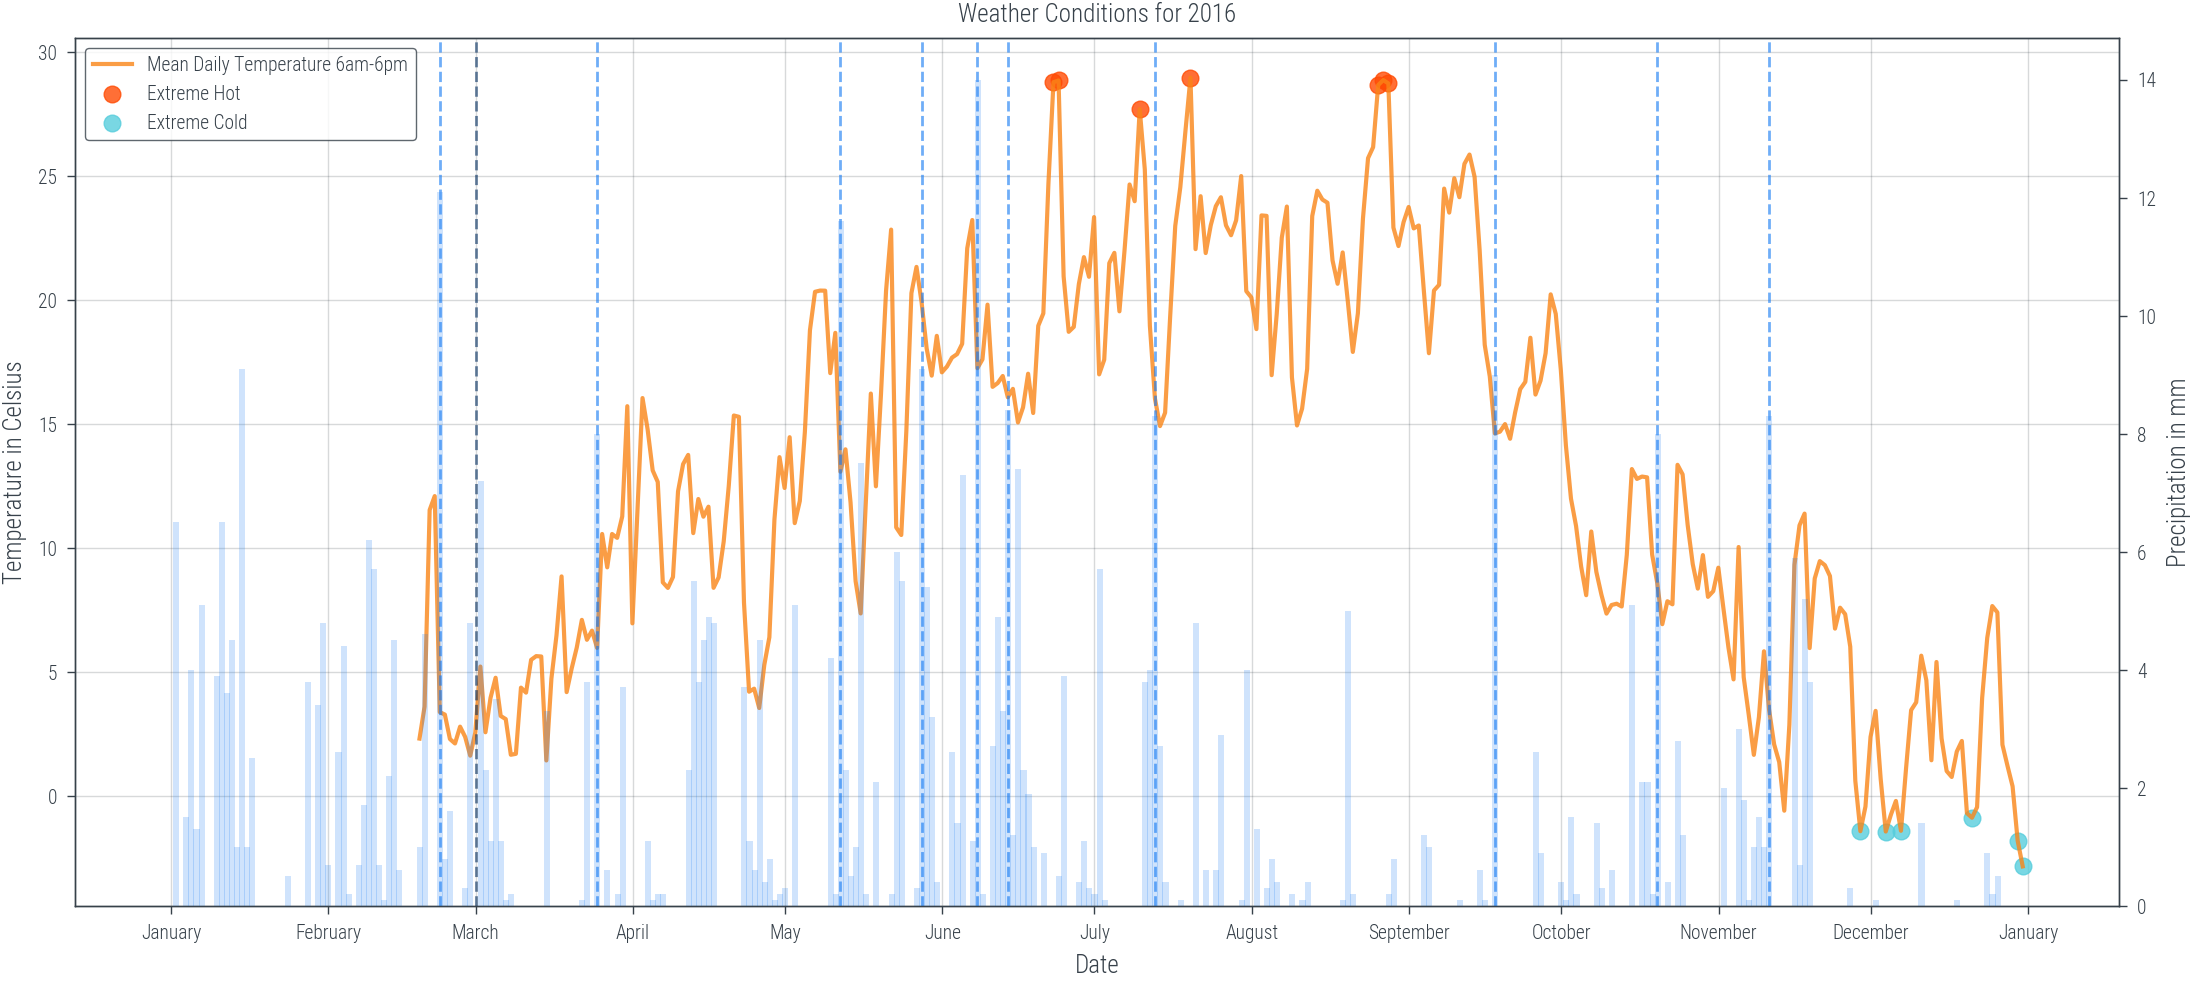

In [60]:
plt.rcParams.update(bundles.beamer_moml(rel_width=2, rel_height=1.6))

year = 2016
fig, ax = plt.subplots(1,1)

# Plot mean temperature data for each day as line plot
during_day_temp_mean_year = hot_temp_day[hot_temp_day.index.year == year]
ax.plot(during_day_temp_mean_year, label='Mean Daily Temperature 6am-6pm', linestyle='-', color=ct.TEMP_COLOR, lw=1.5, alpha=0.8)

# Add markers for X% of extreme hot days 
during_day_temp_extreme_hot_year = hot_day_extreme[hot_day_extreme.index.year == year]
ax.scatter(x=during_day_temp_extreme_hot_year.index,
            y=during_day_temp_extreme_hot_year, alpha=0.8, color=ct.SUMMER_COLOR, label='Extreme Hot')

# Add markers for X% of extreme cold days
during_day_temp_extreme_cold_year = cold_day_extreme[cold_day_extreme.index.year == year]
ax.scatter(x=during_day_temp_extreme_cold_year.index,
            y=during_day_temp_extreme_cold_year, alpha=0.8, color=ct.WINTER_COLOR, label='Extreme Cold')

# Plot precipitation data for each day as bar plot
plt2 = plt.twinx() # this is necessary for second axis!
during_day_weather_precip_sum_year = weather_during_day_df.resample('D', on='iso_timestamp').sum()['precipitation'][weather_during_day_df.resample('D', on='iso_timestamp').sum()['precipitation'].index.year == year]
plt2.bar(x=during_day_weather_precip_sum_year.index,
        height=weather_during_day_df.resample('D', on='iso_timestamp').sum()['precipitation'][weather_during_day_df.resample('D', on='iso_timestamp').sum()['precipitation'].index.year == year],
        label='Summed Precipitation', linestyle='-', color=ct.RAIN_COLOR, alpha=0.2, width=1.2)

# Add markers for extreme precipitation days as vertical lines
during_day_weather_precip_sum_year = precip_day[precip_day.index.year == year]    
during_day_precip_extreme_year = precip_extreme[precip_extreme.index.year == year]
for date in during_day_precip_extreme_year.index:
    plt2.axvline(x=date, color=ct.RAIN_COLOR, linestyle='--', alpha=0.6)

# Add markers for possible black ice days as vertical lines
possible_black_ice_days_year = pd.to_datetime(possible_black_ice_days.index)[pd.to_datetime(possible_black_ice_days.index).year == year]
for date in possible_black_ice_days_year:
    plt2.axvline(x=date, color=ct.RAIN_COLOR*0.4, linestyle='--', alpha=0.6)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%B"))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.grid(which="major", ls="-")
ax.set_title("Weather Conditions for " + str(year))
ax.set_xlabel('Date')
ax.set_ylabel('Temperature in Celsius')
plt2.set_ylabel('Precipitation in mm')
ax.legend(loc="upper left")

plt.show()

/tmp/ipykernel_29785/1166925506.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bike["zählstand"] = df_bike.apply(lambda row: row["zählstand"] / zaehlstand_weekday_max[row["weekday"]], axis=1)


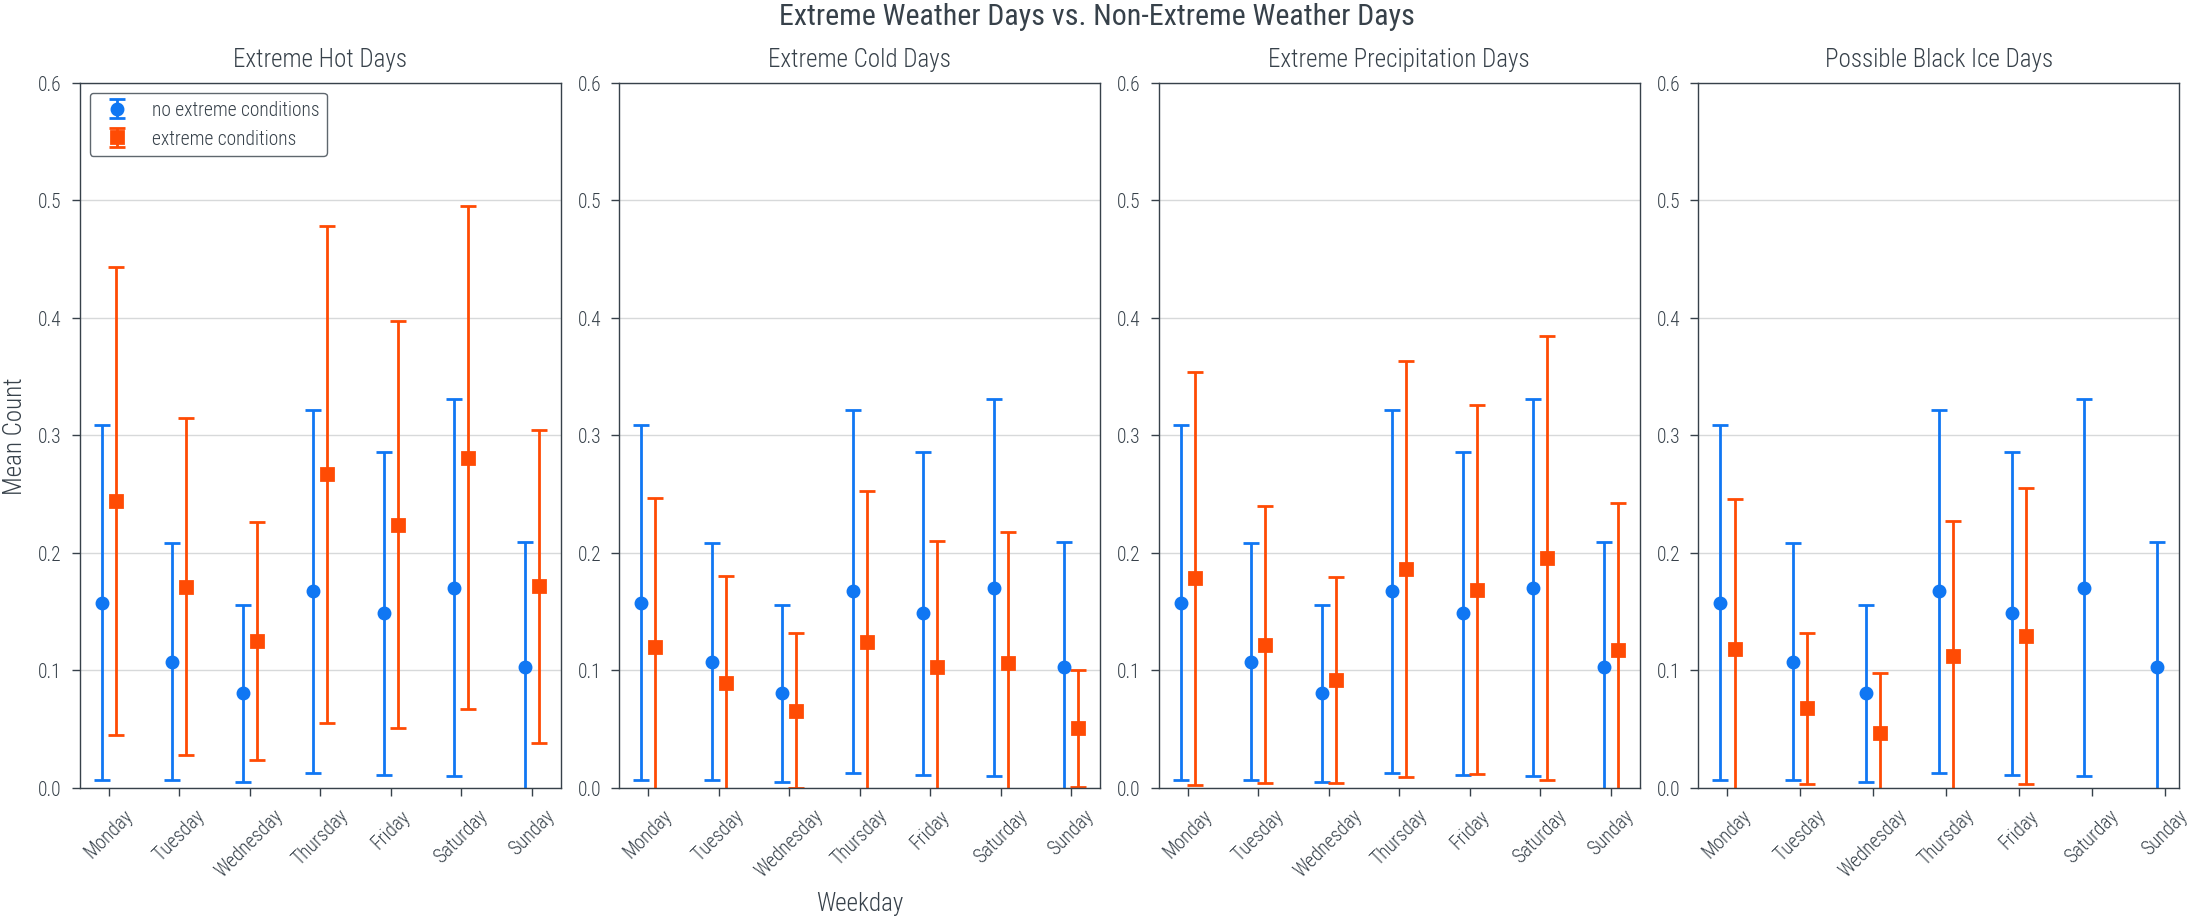

In [72]:
weekday_mapping = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Fahrradtunnel
df_bike = bike_data[bike_data["counter_site_id"].isin([100003358, 100003359])]
# normalize the df at 'zählstand' to 1

zaehlstand_weekday_max = df_bike.groupby(df_bike["iso_timestamp"].dt.weekday)["zählstand"].max()

df_bike["zählstand"] = df_bike.apply(lambda row: row["zählstand"] / zaehlstand_weekday_max[row["weekday"]], axis=1)

df_bike_hot_day_extreme = df_bike[df_bike["iso_timestamp"].dt.date.isin(hot_day_extreme.index.date)]

df_bike_cold_day_extreme = df_bike[df_bike["iso_timestamp"].dt.date.isin(cold_day_extreme.index.date)]

df_bike_precip_day_extreme = df_bike[df_bike["iso_timestamp"].dt.date.isin(precip_day.index.date)]

df_bike_possible_black_ice_days = df_bike[df_bike["iso_timestamp"].dt.date.isin(possible_black_ice_days.index.date)]

df_bike_no_extreme = df_bike[~df_bike["iso_timestamp"].dt.date.isin(hot_day_extreme.index.date) & ~df_bike["iso_timestamp"].dt.date.isin(cold_day_extreme.index.date) & ~df_bike["iso_timestamp"].dt.date.isin(precip_day.index.date) & ~df_bike["iso_timestamp"].dt.date.isin(possible_black_ice_days.index.date)]


df_collection = [[df_bike_no_extreme, df_bike_hot_day_extreme], [df_bike_no_extreme, df_bike_cold_day_extreme], [df_bike_no_extreme, df_bike_precip_day_extreme], [df_bike_no_extreme, df_bike_possible_black_ice_days]]
counter_names = ["Extreme Hot Days", "Extreme Cold Days", "Extreme Precipitation Days", "Possible Black Ice Days"]

plt.rcParams.update(bundles.beamer_moml(rel_width=2, rel_height=1.5))
fig, ax = plt.subplots(1, 4)
# fig.set_size_inches(20, 5)
for i, data in enumerate(df_collection):
    for d in range(7):
        ax[i].errorbar(
            x=d-0.1,
            y=data[0][data[0]["weekday"] == d]["zählstand"].mean(),
            yerr=data[0][data[0]["weekday"] == d]["zählstand"].std(),
            capsize=3,
            fmt="o",
            ms=4,
            color=ct.RAIN_COLOR,
            label="no extreme conditions" if d == 0 else "_nolabel_"
        )
        ax[i].errorbar(
            x=d+0.1,
            y=data[1][data[1]["weekday"] == d]["zählstand"].mean(),
            yerr=data[1][data[1]["weekday"] == d]["zählstand"].std(),
            capsize=3,
            fmt="s",
            ms=4,
            color=ct.SUMMER_COLOR,
            label="extreme conditions" if d == 0 else "_nolabel_"
        )
    ax[i].set_xticks(range(7))
    ax[i].set_xticklabels(weekday_mapping, rotation=45)
    ax[i].set_title(counter_names[i])
    ax[i].grid(axis="y")
    ax[i].set_ylim(bottom=0, top=0.6)
ax[0].set_ylabel("Mean Count")
ax[1].set_xlabel("Weekday")
plt.suptitle("Extreme Weather Days vs. Non-Extreme Weather Days")
ax[0].legend(loc="upper left")
plt.show()